# fit_ellipses
- Given a video and events file, fits an ellipse to every detection when possible
- Outputs a file of the fits, with each row corresponding to a different event
- The file structure looks like:

    - (fitting parameters)
    - [event num, [[ellipse center x, ellipse center y], [ellipse axis 1, ellipse axis 2], ellipse angle for detection 1], [detection 2...], etc.]

# Imports

In [1]:
# Python standard library
import os
import sys
import csv

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

# Load data

In [7]:
date = '7-17-2017/'
particle = '293-T/'
channel = '15-30-15_1/'
file_index = '0'


base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events' + '.json'

In [8]:
# Load video
res_x = 512
res_y = 288
fps = 100000
exposure = 5
oi_vid = oi_file.Video(oi_vid_file_path, res_x, res_y, fps, exposure)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

# Load template and create stage

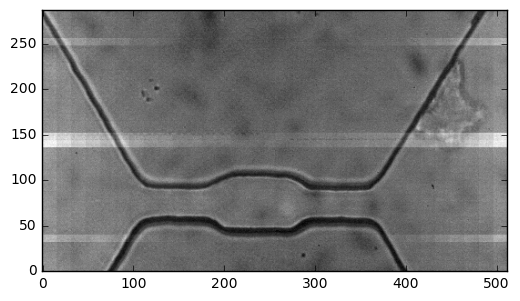

In [11]:
template_index = 1800

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

[-0.  1.]


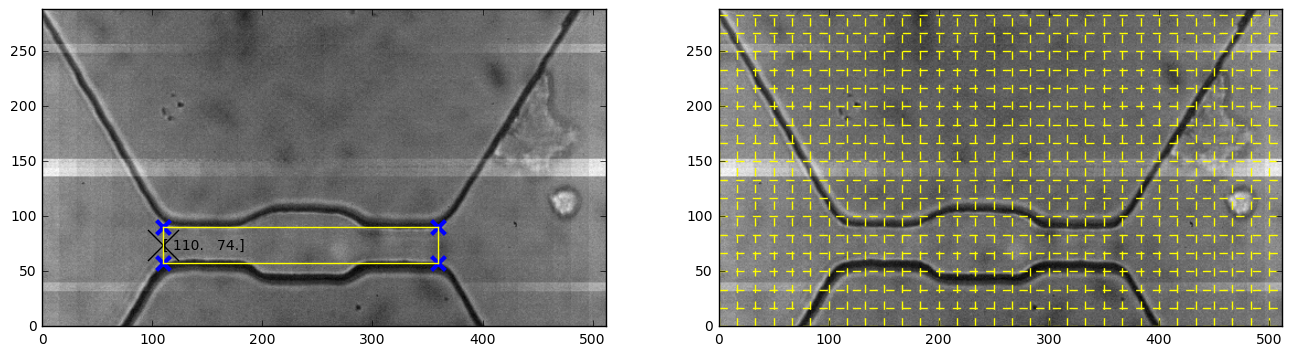

In [10]:
reload(oi)
template_frame = oi_vid.get_frame(template_index)
c0 = [110,90]
c1 = [110,58]
c2 = [360,58]
c3 = [360,90]
oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

# Define functions

In [12]:
def crop_frame(frame, px, py, crop_distance):    
    x0 = int(px - crop_distance)
    x1 = int(px + crop_distance)
    y0 = int(py - crop_distance)
    y1 = int(py + crop_distance)
    cropped_frame = np.copy(frame)[y0:y1, x0:x1]
    
    return cropped_frame
    

preprocessing_steps = []



        


def preprocess_fit_ellipse(raw_frame, raw_template_frame, detection, debug = 'none'):

    
    
    
    # Refresh list
    del preprocessing_steps[:]

    

    
    #################################
    # Copy
    #################################
    
    
    
    preprocessing_steps.append(['copy'])

    processed_template_frame = np.copy(raw_template_frame)
    processed_frame = np.copy(raw_frame)
    

    if debug == 'all':
        print 'copy'
        plot_all(processed_frame, raw_frame)
        
        
    #################################
    # Crop
    #################################
    
    crop_distance = 30
    
    preprocessing_steps.append(['crop'] + [crop_distance])

    processed_frame = crop_frame(processed_frame, detection._px, detection._py, crop_distance)
    processed_template_frame = crop_frame(processed_template_frame, detection._px, detection._py, crop_distance)
    frame = np.copy(processed_frame)

    if debug == 'all':
        print 'crop'
        plot_all(processed_frame, frame)
        
        
        


    
        
    




    #################################
    # Blur
    #################################


    blur_kernel = (9,9)
    preprocessing_steps.append(['gaussian blur', blur_kernel])

    
    processed_frame = cv2.GaussianBlur(processed_frame, blur_kernel, 0)
    processed_template_frame = cv2.GaussianBlur(processed_template_frame, blur_kernel, 0)
    


    if debug == 'all':
        print 'gaussian blur'
        plot_all(processed_frame, frame)
    
    
    #################################
    # Negative
    #################################



    preprocessing_steps.append(['negative'])

    processed_frame = np.abs(processed_frame - processed_template_frame)


    if debug == 'all':
        print 'negative'
        plot_all(processed_frame, frame)

    



    #################################
    # Rescale
    #################################

    preprocessing_steps.append(['rescale'])

    processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))



    if debug == 'all':
        print 'rescale'
        plot_all(processed_frame, frame)
        
    

    #################################
    # Gradient
    #################################

    preprocessing_steps.append(['gradient'])

    processed_frame = cv2.Laplacian(processed_frame, cv2.CV_64F)



    if debug == 'all':
        print 'gradient'
        plot_all(processed_frame, frame)

        
    #################################
    # Rescale
    #################################

    preprocessing_steps.append(['rescale'])

    processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))



    if debug == 'all':
        print 'rescale'
        plot_all(processed_frame, frame)



    #################################
    # Threshold
    #################################

    threshold = .325
    
    preprocessing_steps.append(['pixel intensity threshold', threshold])


    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0
    processed_frame = processed_frame.astype(int)




    if debug == 'all':
        print 'threshold'
        plot_all(processed_frame, frame)




    #################################
    # Erode subtraction
    #################################
    '''
    iterations = 1
    preprocessing_steps.append(['erode subtraction, iterations = ', iterations])


    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)




    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)
    '''



    
    

    #################################    
    # Get largest cluster
    #################################
    '''
    preprocessing_steps.append(['clustering'])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for pixel in largest_cluster:
        processed_frame[pixel[0], pixel[1]] = 1





    if debug == 'all':
        print 'cluster'
        plot_all(processed_frame, frame)
    '''

    
    
    #################################    
    # Cluster filtering
    #################################
    
    
    cluster_threshold = 17
    preprocessing_steps.append(['cluster filtering'])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True, cluster_threshold = cluster_threshold)
    
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for cluster in clusters:
        for pixel in cluster:
            processed_frame[pixel[0], pixel[1]] = 1





    if debug == 'all':
        print 'cluster threshold', cluster_threshold
        plot_all(processed_frame, frame)
    
    
    
    
    
    #################################
    # Pad (numpy)
    #################################
    
    
    pad_width = 20
    #processing_steps.append('pad, pad width = ', pad_width)
    
    processed_frame = np.lib.pad(processed_frame, pad_width, 'constant')
    
    
    if debug == 'all':
        #print 'pad, width = ', pad_width
        plot_all(processed_frame, frame)
    
    
    #################################
    # Morphological closing (opencv)
    #################################
    
    morph_kernel_size = (35,35) #15
    preprocessing_steps.append(['morphological closing, kernel = ', morph_kernel_size])

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)


    if debug == 'all':
        print 'morphological closing'
        plot_all(processed_frame, frame)
    
    
    
    #################################
    # Unpad (numpy)
    #################################
    
    processed_frame = processed_frame[pad_width:-pad_width, pad_width:-pad_width]
    
    
    
    
    
    if debug == 'all':
        #print 'rescale'
        plot_all(processed_frame, frame)
     
    
    
    
    #################################
    # Morphological closing (scipy)
    #################################
    '''
    processed_frame = scipy.ndimage.morphology.binary_closing(processed_frame, structure = np.ones((35,35)))
    
    if debug == 'all':
        print 'morphological closing (scipy)'
        plot_all(processed_frame, frame)
    '''


    #################################
    # Erode subtraction
    #################################
    '''
    iterations = 3
    preprocessing_steps.append(['erosion subtraction, iterations = ', iterations])



    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = iterations)


    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)
    '''
        
        
        
        
    #################################    
    # Get largest cluster
    #################################
    '''
    preprocessing_steps.append(['clustering'])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for pixel in largest_cluster:
        processed_frame[pixel[0], pixel[1]] = 1





    if debug == 'all':
        print 'cluster'
        plot_all(processed_frame, frame)
    '''
        
        
        
    
    #################################
    # Fill holes
    #################################
    
    '''
    preprocessing_steps.append(['fill holes'])

    processed_frame = np.array(scipy.ndimage.binary_fill_holes(processed_frame), dtype = np.uint8)

    print processed_frame.dtype


    if debug == 'all':
        print 'fill holes'
        plot_all(processed_frame, frame)
    '''  
        
    #################################
    # Dilate subtraction
    #################################
    
    iterations = 3
    preprocessing_steps.append(['dilation subtraction, iterations = ', iterations])

    processed_frame = scipy.ndimage.binary_dilation(processed_frame) - processed_frame


    if debug == 'all':
        print 'dilate subtraction'
        plot_all(processed_frame, frame)
    
    
    
    
    
        
        
        
    
 


    ###################################
    # Fit ellipse
    ###################################


    cell_pixels = np.where(processed_frame == 1)

    ellipse = oi.fit_ellipse(cell_pixels[1], cell_pixels[0])

    # Center
    ellipse_center = oi.get_ellipse_center(ellipse)
    ellipse_center_adjusted = [ellipse_center[0] + detection._px - crop_distance, ellipse_center[1] + detection._py - crop_distance]

    # Axes
    ellipse_axes_lengths = oi.get_ellipse_axes_lengths(ellipse)
    
    # Angle
    ellipse_angle = oi.get_ellipse_angle(ellipse)

    
    
    if debug != 'none':
        # Create perimeter line
        ellipse_points = np.empty((100,2))
        for i in range(100):
            angle = i*2*np.pi/99.
            x = ellipse_axes_lengths[0]*np.cos(angle)
            y = ellipse_axes_lengths[1]*np.sin(angle)
            ellipse_points[i,0] = ellipse_center[0] + np.cos(ellipse_angle)*x + np.sin(ellipse_angle)*y
            ellipse_points[i,1] = ellipse_center[1] + np.sin(ellipse_angle)*x - np.cos(ellipse_angle)*y

        # Turn pixels green
        green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
        green_processed_frame[:,:,1] = processed_frame

        # Begin plot
        fig, axes = plt.subplots(1,3,figsize = (12,3))
        
        
        # Axes 0
        plt.sca(axes[0])
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])

        
        # Axes 1
        plt.sca(axes[1])
        
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        #plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 3, c = 'red')

        #plt.scatter(ellipse_center[0], ellipse_center[1], marker = 'x', lw = 5, color = 'red', s = 50)
        
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])
        
        
        # Axes 2
        plt.sca(axes[2])
        
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        #plt.imshow(processed_frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 3, c = 'red')

        plt.scatter(ellipse_center[0], ellipse_center[1], marker = 'x', c = 'red', lw = 3, s = 20)
        
        
        ellipse_axis_a = [ellipse_axes_lengths[0]*np.cos(ellipse_angle), ellipse_axes_lengths[0]*np.sin(ellipse_angle)]
        ellipse_axis_b = [ellipse_axes_lengths[1]*np.sin(ellipse_angle), -ellipse_axes_lengths[1]*np.cos(ellipse_angle)]

        
        ax0 = ellipse_center[0]
        ax1 = ax0 + ellipse_axis_a[0]
        ay0 = ellipse_center[1]
        ay1 = ay0 + ellipse_axis_a[1]
        
        bx0 = ellipse_center[0]
        bx1 = bx0 + ellipse_axis_b[0]
        by0 = ellipse_center[1]
        by1 = by0 + ellipse_axis_b[1]
        
        plt.plot([ax0, ax1], [ay0, ay1], lw = 3, c = 'red')
        plt.plot([bx0, bx1], [by0, by1], lw = 3, c = 'red')
        
        plt.text((ax0+ax1)/2., (ay0+ay1)/2., 'a', color = 'red', size = 20, ha = 'left', va = 'bottom')
        plt.text((bx0+bx1)/2., (by0+by1)/2., 'b', color = 'red', size = 20, ha = 'left', va = 'bottom')
        
        plt.text(1, 0.2, r'$|a|=$'+str(round(ellipse_axes_lengths[0],3)), transform=plt.gca().transAxes, ha = 'right', va = 'bottom', size = 12, color = 'red')
        plt.text(1, 0.1, r'$|b|=$'+str(round(ellipse_axes_lengths[1],3)), transform=plt.gca().transAxes, ha = 'right', va = 'bottom', size = 12, color = 'red')

        plt.text(1, 0, r'$\theta=$'+str(round(ellipse_angle*180./np.pi,3)), transform=plt.gca().transAxes, ha = 'right', va = 'bottom', size = 12, color = 'red')
        
        
        
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])
        
        plt.grid()
                
        plt.show()
        
        
    return [ellipse_center_adjusted[0], ellipse_center_adjusted[1], ellipse_axes_lengths[0], ellipse_axes_lengths[1], ellipse_angle]


# Preprocess, fit ellipse to all detections, calculate aspect ratios at every frame

In [13]:
ellipsess = []
detection_indicess = []


for i, oi_event in enumerate(oi_events):
    print 'event', i, '/', len(oi_events)
    
    
    ellipsess.append([])
    detection_indicess.append([])
    
    
    for j, detection in enumerate(oi_event._detections):
        
        try:

            # Get raw frame
            frame = oi_vid.get_frame(detection._tf)

            # Preprocess and fit ellipse
            ellipse = preprocess_fit_ellipse(frame, template_frame, detection, debug = 'none')
            ellipsess[-1].append([j] + ellipse)

            
        except Exception as e:
            #exc_type, exc_obj, exc_tb = sys.exc_info()
            #fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            #print(exc_type, fname, exc_tb.tb_lineno)
            
            print '\tfailed on', j, '/', len(oi_event._detections)

event 0 / 157
	failed on 0 / 136
	failed on 1 / 136
	failed on 2 / 136
	failed on 3 / 136
	failed on 4 / 136
	failed on 5 / 136
	failed on 6 / 136
	failed on 7 / 136
	failed on 8 / 136
	failed on 9 / 136
	failed on 10 / 136
	failed on 11 / 136
	failed on 12 / 136
	failed on 13 / 136
	failed on 14 / 136
	failed on 15 / 136
	failed on 16 / 136
	failed on 17 / 136
	failed on 18 / 136
	failed on 19 / 136
	failed on 20 / 136
	failed on 21 / 136
event 1 / 157
	failed on 0 / 172
	failed on 1 / 172
	failed on 2 / 172
	failed on 3 / 172
	failed on 4 / 172
	failed on 5 / 172
	failed on 6 / 172
	failed on 7 / 172
	failed on 8 / 172
	failed on 9 / 172
	failed on 10 / 172
	failed on 11 / 172
	failed on 12 / 172
	failed on 13 / 172
	failed on 14 / 172
	failed on 15 / 172
	failed on 16 / 172
	failed on 17 / 172
	failed on 18 / 172
	failed on 19 / 172
	failed on 20 / 172
	failed on 21 / 172
	failed on 22 / 172
	failed on 23 / 172
	failed on 24 / 172
	failed on 25 / 172
	failed on 26 / 172
	failed on 2

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:532: RuntimeWarning: invalid value encountered in sqrt
  res1=np.sqrt(up/down1)


	failed on 110 / 153
	failed on 111 / 153
	failed on 112 / 153
	failed on 113 / 153
	failed on 114 / 153
	failed on 115 / 153
	failed on 116 / 153
	failed on 117 / 153
	failed on 118 / 153
	failed on 119 / 153
	failed on 120 / 153
	failed on 121 / 153
	failed on 122 / 153
	failed on 123 / 153
	failed on 124 / 153
	failed on 125 / 153
	failed on 126 / 153
	failed on 127 / 153
	failed on 128 / 153
	failed on 129 / 153
	failed on 130 / 153
	failed on 131 / 153
	failed on 132 / 153
	failed on 133 / 153
	failed on 134 / 153
	failed on 135 / 153
	failed on 136 / 153
	failed on 137 / 153
	failed on 138 / 153
	failed on 139 / 153
	failed on 140 / 153
	failed on 141 / 153
	failed on 142 / 153
	failed on 143 / 153
	failed on 144 / 153
	failed on 145 / 153
	failed on 146 / 153
	failed on 147 / 153
	failed on 148 / 153
	failed on 149 / 153
	failed on 150 / 153
	failed on 151 / 153
	failed on 152 / 153
event 6 / 157
	failed on 0 / 75
	failed on 1 / 75
	failed on 2 / 75
	failed on 3 / 75
	failed on 

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:533: RuntimeWarning: invalid value encountered in sqrt
  res2=np.sqrt(up/down2)


event 7 / 157
	failed on 0 / 128
	failed on 1 / 128
	failed on 2 / 128
	failed on 3 / 128
	failed on 4 / 128
	failed on 5 / 128
	failed on 6 / 128
	failed on 7 / 128
	failed on 8 / 128
	failed on 9 / 128
	failed on 10 / 128
	failed on 11 / 128
	failed on 12 / 128
	failed on 13 / 128
	failed on 14 / 128
	failed on 15 / 128
	failed on 16 / 128
	failed on 17 / 128
	failed on 18 / 128
	failed on 19 / 128
event 8 / 157
	failed on 0 / 212
	failed on 1 / 212
	failed on 2 / 212
	failed on 3 / 212
	failed on 4 / 212
	failed on 5 / 212
	failed on 6 / 212
	failed on 7 / 212
	failed on 8 / 212
	failed on 9 / 212
	failed on 10 / 212
	failed on 11 / 212
	failed on 12 / 212
	failed on 13 / 212
	failed on 14 / 212
	failed on 15 / 212
	failed on 16 / 212
	failed on 17 / 212
	failed on 18 / 212
	failed on 19 / 212
	failed on 20 / 212
	failed on 21 / 212
	failed on 22 / 212
	failed on 23 / 212
	failed on 24 / 212
	failed on 25 / 212
	failed on 26 / 212
	failed on 27 / 212
	failed on 28 / 212
	failed on 2

# Save ellipses

In [14]:
output_file_path = '../data/' + date + particle + channel + 'ellipses_' + file_index
print output_file_path

../data/7-17-2017/293-T/15-30-15_1/ellipses_0


In [15]:
with open(output_file_path, 'w') as file_handle:
    file_writer = csv.writer(file_handle, delimiter = '\t')
    
    # Write preprocessing steps
    file_writer.writerow(preprocessing_steps)
    
    # Write ellipse info
    file_writer.writerow(['detection index', 'ellipse center x', 'ellipse center y', 'ellipse axes x', 'ellipse axes y', 'ellipse angle'])
    
    # Write ellipse
    for i, ellipses in enumerate(ellipsess):
        file_writer.writerow(['event #', i])
        for ellipse in ellipses:
            file_writer.writerow(ellipse)

In [9]:
print len(ellipsess)

278
